In [1]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Graph_structure_research"
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [2]:
%pwd


'c:\\Users\\Maza\\Desktop\\Pinecone_pipeline\\research'

In [3]:
os.chdir("../")
%pwd

'c:\\Users\\Maza\\Desktop\\Pinecone_pipeline'

In [4]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class GraphStructureConfig:
    root_dir: Path
    graph_structure_file: Path
    sructure_file: Path
    graph_json_model:Path
    models: dict
    graph_prompts: dict
    human_review: str

In [5]:
from langgraph.graph import END, StateGraph
from typing_extensions import TypedDict
@dataclass(frozen=True)
class GraphSchemaState(TypedDict):
   
    dir_schema : dict
    draft_graph_schema : dict
    human_feedback : str
    agent_feedback : str
    final_schema : dict
    num_steps : int

In [6]:
from langchain_core.prompts import PromptTemplate
from langchain_groq import ChatGroq
from vector_db_pipeline.constants import *
from vector_db_pipeline.utils.common import read_yaml,  create_directories, load_json
from vector_db_pipeline import logger
from dotenv import load_dotenv
from graphviz import Digraph
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from IPython.display import Image, display
load_dotenv()

True

In [7]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        models_filepath = MODELS_FILE_PATH,
        prompt_template = PROMPT_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.schema = read_yaml(schema_filepath)
        self.params = read_yaml(params_filepath)
        self.models = read_yaml(models_filepath)
        self.prompt_template = read_yaml(prompt_template)
    
        

    
    def get_graph_structure_config(self) -> GraphStructureConfig:
        config = self.config.graph_structure
        prompt_teplates = self.prompt_template.generate_graph_structure
        create_directories([config.root_dir])
        
        graph_structure_config = GraphStructureConfig(
            root_dir=config.root_dir,
            graph_structure_file = config.graph_structure_file,
            sructure_file = config.sructure_file,
            graph_json_model = config.graph_json_model,
            human_review = config.human_review,
            models = self.models,
            graph_prompts = prompt_teplates
        ) 

        return graph_structure_config

In [8]:
"""
Manages the generation of graph structures and visualization.

Attributes:
    config (GraphStructureConfig): Configuration object for the GraphStructure class.

Methods:
    graph_schema_agents(): Initializes the agents for generating, reviewing, and editing the graph schema.
    generate_schema(state): Generates the initial draft of the graph schema.
    schema_reviewer(state): Reviews the generated draft schema.
    human_reviewer(state): Facilitates human review of the agent's feedback on the draft schema.
    route_to_edit(state): Determines the next step based on the agent feedback.
    schema_editor(state): Edits the draft schema based on feedback from the reviewer agent.
    state_printer(state): Prints the current state of the processing.
    create_graph_agents(workflow): Creates and configures the workflow for the graph schema generation process.
    run_schema_agents(app): Runs the agent workflow to generate and review the graph schema.
    generate_graph_viz_and_render(graph_model): Generates and renders the graph visualization.
"""
class GraphStructure:
    def __init__(self, config:GraphStructureConfig):
        """
        Initializes the GraphStructure object with the given configuration.

        Args:
            config (GraphStructureConfig): Configuration object for the GraphStructure class.
        """
        self.config = config


    def graph_schema_agents(self):
        """
        Initializes the agents for generating, reviewing, and editing the graph schema.

        This method sets up three agents using templates and the specified language model:
        - graph_schema_gen_agent: Generates a draft schema.
        - graph_schema_reviewer_agent: Reviews the generated schema.
        - graph_schema_editor_agent: Edits the schema based on feedback.
        """
        models = self.config.models
        model = models.Llama3
        logger.info(f"Working with model: {model}")
        llm = ChatGroq(temperature=0, model_name=model)
        

        #Agents

        #graph schema genetrator

        graph_schema_gen_promt = PromptTemplate(
            template= self.config.graph_prompts.prompt_graph_schema_generator,
            input_variables=["dir_schema"])
        self.graph_schema_gen_agent = graph_schema_gen_promt | llm | JsonOutputParser()
        
        
        # graph schema reviewer
        
        graph_schema_reviewer_promt = PromptTemplate(
            template= self.config.graph_prompts.prompt_graph_schema_reviewer,
            input_variables=["current_model"])
        self.graph_schema_reviewer_agent = graph_schema_reviewer_promt | llm | StrOutputParser()
        

        # graph schema editor
        
        graph_schema_editor_promt = PromptTemplate(
            template= self.config.graph_prompts.prompt_graph_schema_editor,
            input_variables=["feedback", "current_model"])
        self.graph_schema_editor_agent = graph_schema_editor_promt | llm | JsonOutputParser()
        
        
        
    def generate_schema(self,state):
        """
        Generates the initial draft of the graph schema.

        Args:
            state (dict): Current state containing the directory schema and number of steps.

        Returns:
            dict: Updated state with the draft graph schema and incremented step count.
        """
  
        logger.info(f"Creating draft schema")
        dir_schema = state['dir_schema']
        num_steps = int(state['num_steps'])
        num_steps += 1
        try:
            graph_schema = self.graph_schema_gen_agent.invoke({"dir_schema": str(dir_schema)})
            logger.info(f"Finish creating draft schema")
        except Exception as e:
            logger.error(f"Error while generating schema: {e}")
        self.generate_graph_viz_and_render(graph_schema)
        
        return {"draft_graph_schema": graph_schema, "num_steps":num_steps}
    
    def schema_reviewer(self,state):
        """
        Reviews the generated draft schema.

        Args:
            state (dict): Current state containing the draft graph schema and number of steps.

        Returns:
            dict: Updated state with the agent feedback and incremented step count.
        """
        logger.info(f"Reviewing draft schema")
        dir_schema = state['dir_schema']
        current_model = state["draft_graph_schema"]
        num_steps = int(state['num_steps'])
        num_steps += 1

        try:
            agent_feedback = self.graph_schema_reviewer_agent.invoke({"current_model": current_model, })
            logger.info(f"Finish reviewing draft schema")
        except Exception as e:
            logger.error(f"Error while reviewing schema: {e}")
        

        return {"agent_feedback": agent_feedback, "num_steps":num_steps}
    
    
    def human_reviewer(self,state):
        """
        Facilitates human review of the agent's feedback on the draft schema.

        Args:
            state (dict): Current state containing agent feedback.

        Returns:
            dict: Updated state with human feedback.
        """
        if self.config.human_review:
            
            feedback = state['agent_feedback']
            print(f"Feedback: \n {feedback}")
            print("Enter yes if you agree with agent feedback:")
            human_approve = input()
            print(human_approve.lower())

            if human_approve.lower() == "yes":
                return {"human_feedback": "proceed with agent feedback"}
            
            else:
                print("Do you want to propose any feedback (yes or no):")
                human_review = input()
                print(human_review.lower())
                
                if human_review.lower() == 'no':
                
                    return {"agent_feedback":"no changes", "human_feedback": "model is correct", "final_schema": state["draft_graph_schema"]}
                
                else:
                    print("Enter your feedback:")
                    human_feedback = input()
                    print(human_feedback)
                    return {"agent_feedback": human_feedback, "human_feedback": human_feedback}
        else:
            return {"human_feedback": "No human in the loop"}

    def route_to_edit(self, state):
        """
        Determines the next step based on the agent feedback.

        Args:
            state (dict): Current state containing agent feedback.

        Returns:
            str: The next step ("no_edit" or "edit").
           
        """
     
       
        if state["agent_feedback"] == "no changes":

            logger.info(f"Schema does not need changes.")
            return "no_edit"
        
        else:
            logger.info(f"Schema does need changes, sending feedback to editor agent.")
            return "edit"
    
    
    
    def schema_editor(self,state):
        """
        Edits the draft schema based on feedback from the reviewer agent.

        Args:
            state (dict): Current state containing the draft graph schema, agent feedback, and number of steps.

        Returns:
            dict: Updated state with the final schema and incremented step count.
        """

        logger.info(f"Editing draft schema using feedback from graph_schema_reviewer_agent")
        current_model = state["draft_graph_schema"]
        feedback = state["agent_feedback"]
        num_steps = int(state['num_steps'])
        num_steps += 1

        try:
            edited_schema = self.graph_schema_editor_agent.invoke({"feedback":feedback,"current_model": str(current_model)})
            logger.info(f"Finish editing draft schema using feedback from graph_schema_reviewer_agent")
            self.generate_graph_viz_and_render(edited_schema)
            
        except Exception as e:
            return logger.error(f"Error while editing schema: {e}")
        
        return {"final_schema": edited_schema, "num_steps":num_steps}

    
    def state_printer(self,state):
        """
        Prints the current state of the processing.

        Args:
            state (dict): The current state of the processing.
        """
        
        logger.info("---STATE PRINTER---")
        logger.info(f"Agent feedback: {state['agent_feedback']} \n")
        logger.info(f"Human feedback: {state['human_feedback']} \n")
        logger.info(f"Num Steps: {state['num_steps']} \n")
       

    def create_graph_agents(self, workflow):
        """
        Creates and configures the workflow for the graph schema generation process.

        Args:
            workflow (Workflow): The workflow object to configure.

        Returns:
            app (Application): The compiled workflow application.
        """
        
        #nodes
        workflow.add_node("generate_schema", self.generate_schema) 
        workflow.add_node("schema_reviewer", self.schema_reviewer)
        workflow.add_node("human_reviewer", self.human_reviewer)
        workflow.add_node("schema_editor", self.schema_editor)
        workflow.add_node("state_printer", self.state_printer)

        #edges
        workflow.set_entry_point("generate_schema")
        workflow.add_edge("generate_schema","schema_reviewer")
        workflow.add_edge("schema_reviewer","human_reviewer")
        workflow.add_conditional_edges(
            "human_reviewer",
            self.route_to_edit,
            {
                "no_edit": "state_printer",
                "edit": "schema_editor",
            },
        )
      
        workflow.add_edge("schema_editor", "state_printer")
        workflow.add_edge("state_printer", END)

        #compile
        try:
            app = workflow.compile()
            logger.info("Agent graph created")
        except Exception as e:
            logger.error(f"Agent graph error: {e}")
             
        return  app
    
    def run_schema_agents(self,app):
        """
        Runs the agent workflow to generate and review the graph schema.

        Args:
            app (Application): The compiled workflow application.

        Returns:
            dict: The final output of the workflow execution.
        """
        dir_schema = load_json(Path(self.config.sructure_file))
        inputs = {"dir_schema": dir_schema,"num_steps":0}
        try:
            logger.info("Initialazing agent workflow")
            output = app.invoke(inputs)
        except Exception as e:
            return logger.error(f"Agent orquestration failed : {e}")
        
        logger.info("Finalizing agent workflow")
        return output

    
    def generate_graph_viz_and_render(self,graph_model):
        """
        Generates and renders the graph visualization.

        Args:
            graph_model (dict): The graph model to visualize.

        Returns:
            None
        """
        try:
            filename = self.config.graph_structure_file
           

        
            graph = Digraph(engine='neato',node_attr={'shape': 'Mrecord'}, format="png")

            for c in graph_model['entities']:
                attnames = (x['name'] + "\n(sch:" + x['schema_org_term'][18:] + ") " for x in c['attributes'])
                graph.node(c['name'].replace(" ","_")+"_node",   "{ Entity: " + c['name']
                            + "\n(sch:" + c['schema_org_term'][18:] + ") " + "|" + "|".join(attnames) + "}")   

            for r in graph_model['relationships']:
                graph.edge(r['from'].replace(" ","_") + "_node",r['to'].replace(" ","_") + "_node",
                            label=r['name'] + "\n(sch:" + r['schema_org_term'][18:] + ") " , len='6.00')

            graph.render(filename)
            logger.info(f"Graph image saved in  {filename+'.png'}")
            display(Image(filename + ".png"))
        except Exception as e:
            logger.info(f"Error while generating graph: {e}")
        Image(filename + ".png")


[2024-06-06 11:36:13,748: INFO: common: yaml file: config\config.yaml loaded successfully:]
[2024-06-06 11:36:13,768: INFO: common: yaml file: schema.yaml loaded successfully:]


[2024-06-06 11:36:13,784: INFO: common: yaml file: params.yaml loaded successfully:]
[2024-06-06 11:36:13,795: INFO: common: yaml file: models.yaml loaded successfully:]
[2024-06-06 11:36:13,817: INFO: common: yaml file: prompt_template.yaml loaded successfully:]
[2024-06-06 11:36:13,819: INFO: common: Directory already exists: artifacts/graph_structure:]
[2024-06-06 11:36:13,820: INFO: 2566555841: Working with model: llama3-70b-8192:]
[2024-06-06 11:36:16,503: INFO: 2566555841: Agent graph created:]
[2024-06-06 11:36:16,519: INFO: common: json file loaded succesfully from: artifacts\json_summary\json_summary_edited.json:]
[2024-06-06 11:36:16,524: INFO: 2566555841: Initialazing agent workflow:]
[2024-06-06 11:36:16,653: INFO: 2566555841: Creating draft schema:]
[2024-06-06 11:36:20,732: INFO: _client: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK":]
[2024-06-06 11:36:20,766: INFO: 2566555841: Finish creating draft schema:]
[2024-06-06 11:36:21,303

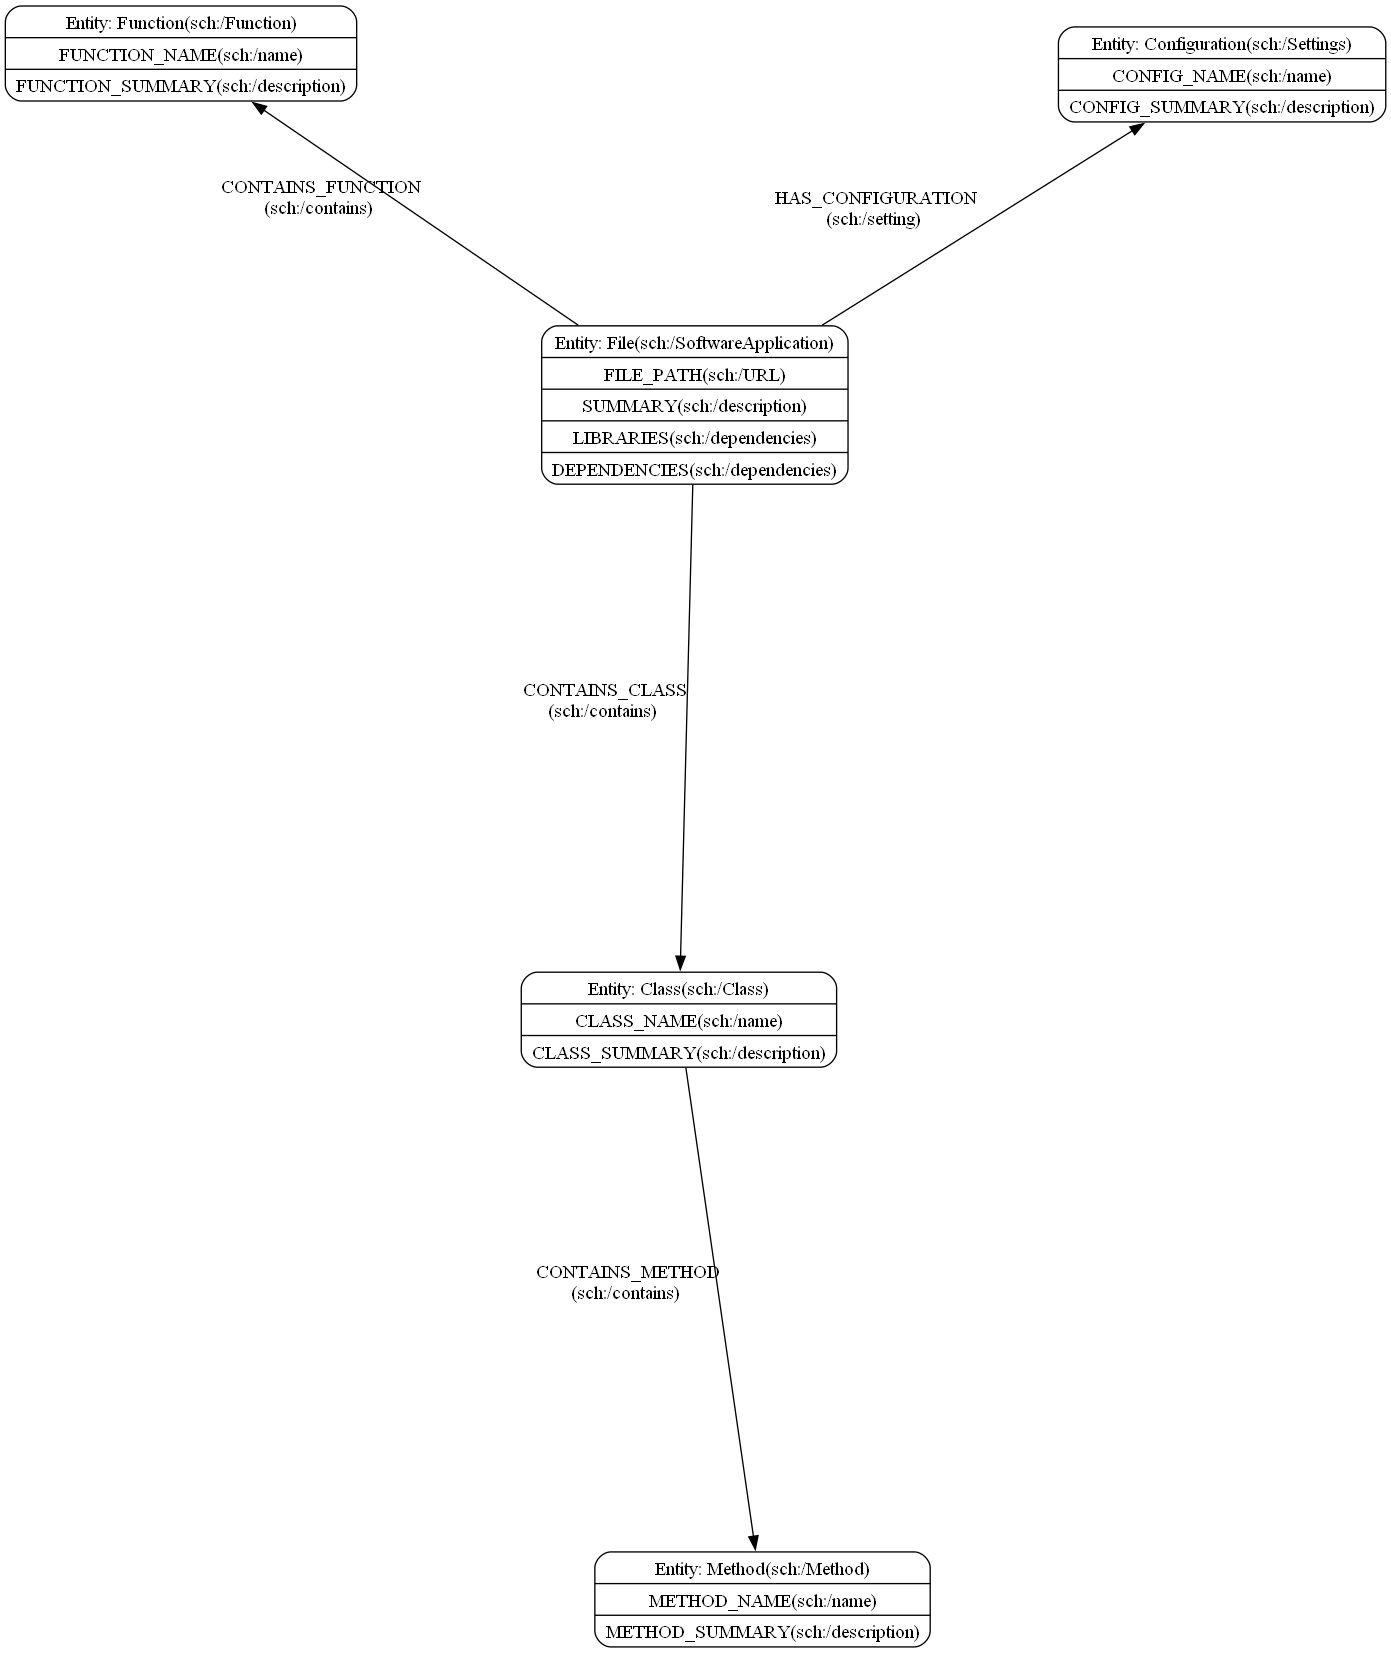

[2024-06-06 11:36:21,416: INFO: 2566555841: Reviewing draft schema:]
[2024-06-06 11:36:24,264: INFO: _client: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK":]
[2024-06-06 11:36:24,272: INFO: 2566555841: Finish reviewing draft schema:]
Feedback: 
 Extract 'LIBRARIES' and 'DEPENDENCIES' from 'File' entity as a separate entity 'Dependency' with attributes 'LIBRARY' and 'DEPENDENCY' respectively, and create relationships 'HAS_DEPENDENCY' from 'File' to 'Dependency'.
Enter yes if you agree with agent feedback:
yes
[2024-06-06 11:36:34,973: INFO: 2566555841: Schema does need changes, sending feedback to editor agent.:]
[2024-06-06 11:36:35,004: INFO: 2566555841: Editing draft schema using feedback from graph_schema_reviewer_agent:]
[2024-06-06 11:36:38,202: INFO: _client: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK":]
[2024-06-06 11:36:38,202: INFO: 2566555841: Finish editing draft schema using feedback from graph_

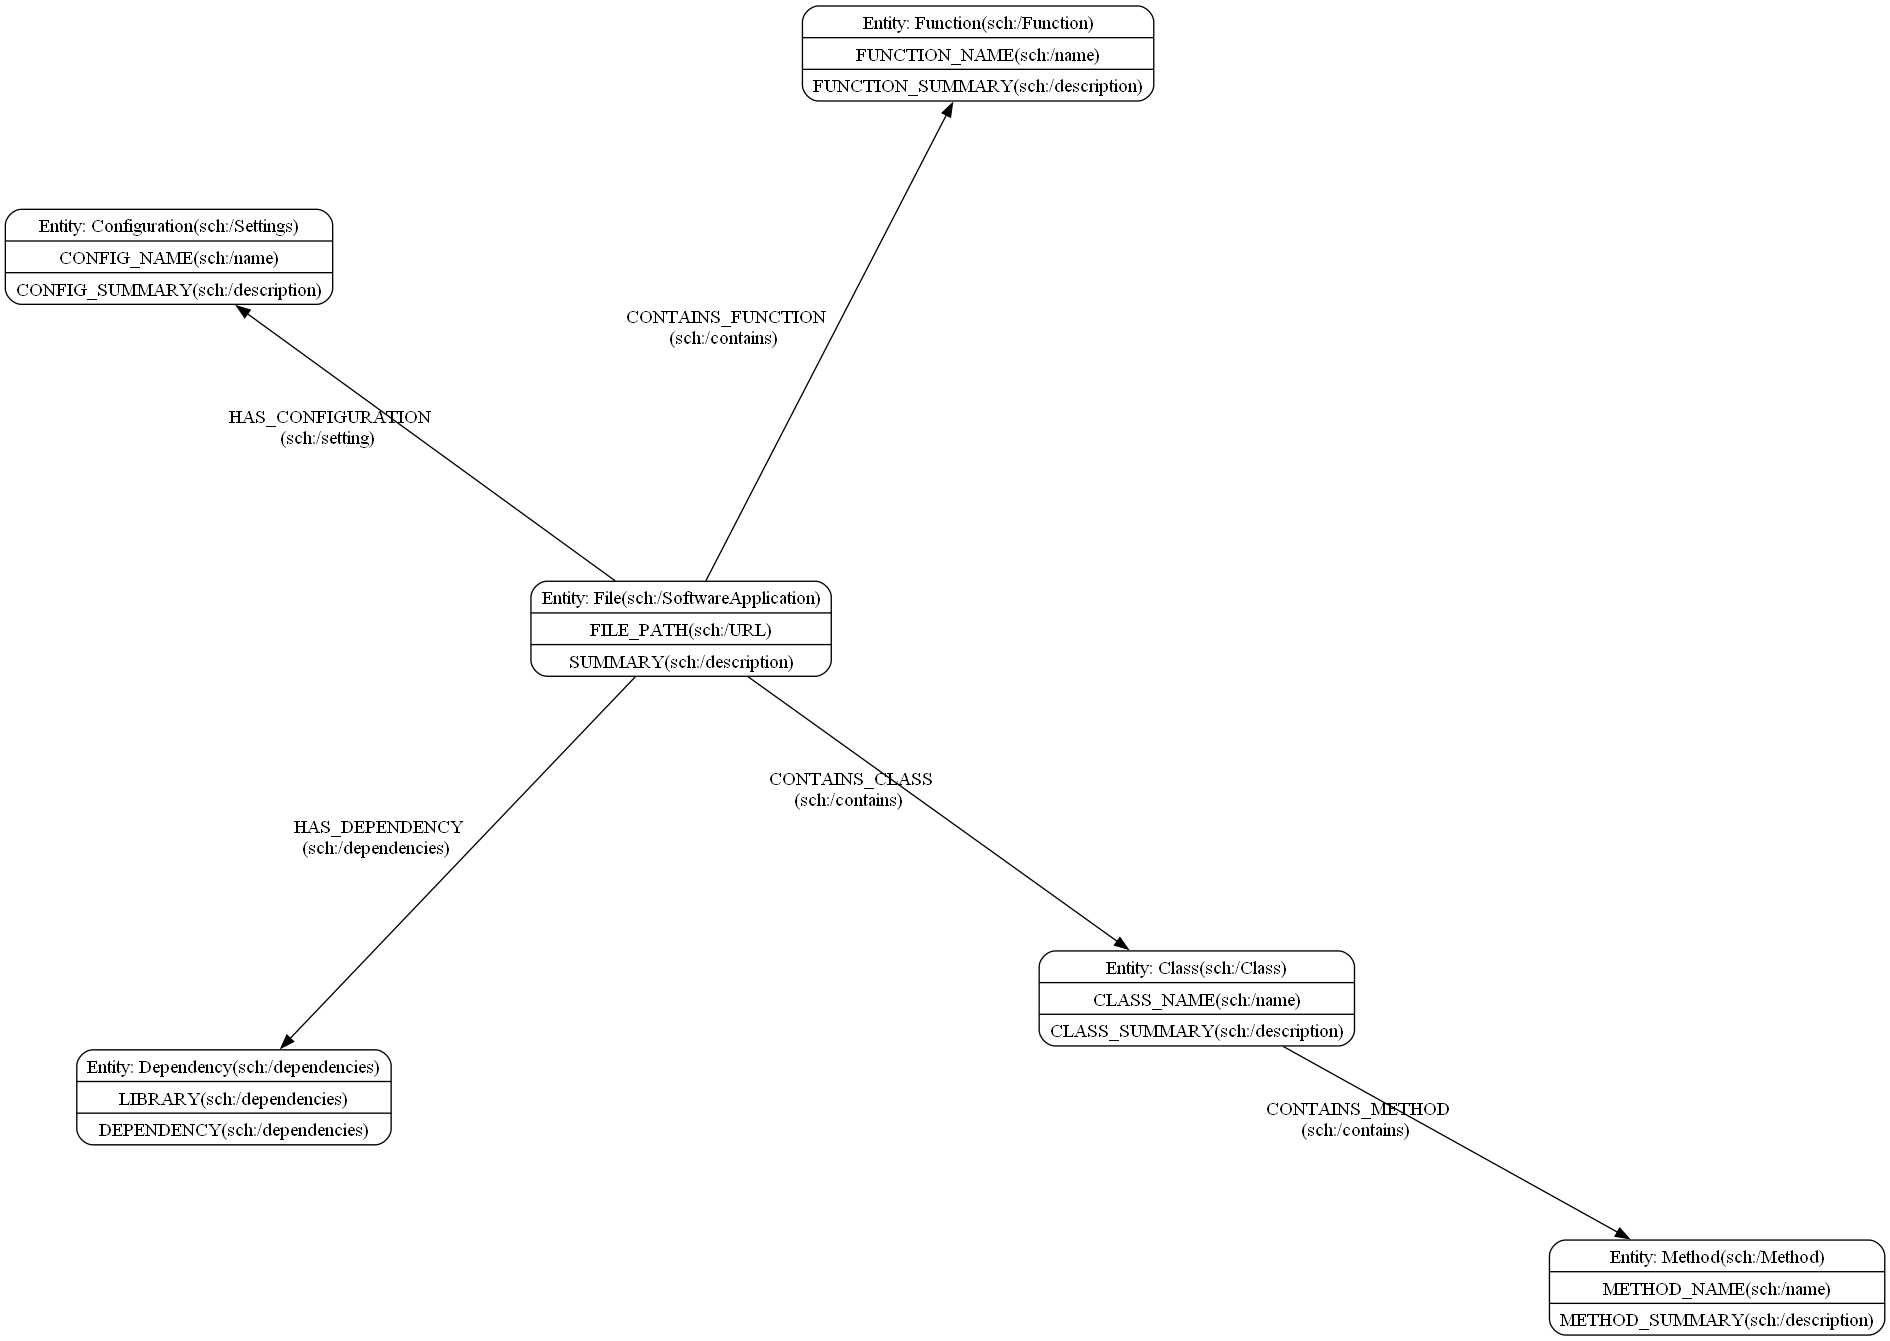

[2024-06-06 11:36:38,387: INFO: 2566555841: ---STATE PRINTER---:]
[2024-06-06 11:36:38,388: INFO: 2566555841: Agent feedback: Extract 'LIBRARIES' and 'DEPENDENCIES' from 'File' entity as a separate entity 'Dependency' with attributes 'LIBRARY' and 'DEPENDENCY' respectively, and create relationships 'HAS_DEPENDENCY' from 'File' to 'Dependency'. 
:]
[2024-06-06 11:36:38,388: INFO: 2566555841: Human feedback: proceed with agent feedback 
:]
[2024-06-06 11:36:38,389: INFO: 2566555841: Num Steps: 3 
:]
[2024-06-06 11:36:38,397: INFO: 2566555841: Finalizing agent workflow:]


In [9]:
config = ConfigurationManager()
graph_structure_config = config.get_graph_structure_config()
graph_structure = GraphStructure(config=graph_structure_config)
graph_structure.graph_schema_agents()
app = graph_structure.create_graph_agents(StateGraph(GraphSchemaState))
output_ = graph_structure.run_schema_agents(app)